### Feature selection based on "****information gain && Fast Correlation Based Filter (FCBF)****" 

During the second phase, I encountered suboptimal outcomes for specific attack categories, notably Infiltration and WebAttack. This was primarily attributed to the insufficient volume of data available for these particular attack types. Consequently, in the  third phase, I undertook a strategic approach by leveraging the **CSE-CIC-IDS2018 and HTTP datasets**. The objective was to reinforce the database's representation of certain attacks, namely BruteForce, Bot, WebAttack, and Infiltration. To align the distribution, I rounded up the number of instances for these attacks to match the count of the other classes.

**For BruteForce, an augmentation of 28,233 instances was introduced, while Bot saw the addition of 30,607 instances. Similarly, Infiltration was enriched by an inclusion of 30,993 records from the CSE-CIC-IDS2018 dataset. To address the scarcity of WebAttack instances in the CSE-CIC-IDS2018 dataset, 30,563 instances were integrated from the HTTP dataset.**

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset

In [3]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_20Percent_resampled.csv')
# The results in this code is based on the original CICIDS2017 dataset.

In [4]:
df

,DestinationPort,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,80,538750,3,6,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DoS
1,53580,74,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
2,53,33686,2,2,64,248,32,32,32.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
3,80,5313019,3,1,12,0,6,0,4.000000,3.464102,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
4,53,23299,1,1,49,114,49,49,49.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normaltraffic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686536,80,5386626,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack
686537,80,5487373,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack
686538,80,5621517,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack
686539,80,5580559,3,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,WebAttack


In [5]:
df.Label.value_counts()

Normaltraffic    454619
DoS               76136
PortScan          31786
BruteForce        31000
Bot               31000
WebAttack         31000
Infiltration      31000
Name: Label, dtype: int64

### Preprocessing (normalization and padding values)

In [6]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [9]:
df.Label.value_counts()

Normaltraffic    454619
DoS               76136
PortScan          31786
BruteForce        31000
Bot               31000
WebAttack         31000
Infiltration      31000
Name: Label, dtype: int64

In [10]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

In [11]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

## Feature engineering

### Feature selection by information gain

In [13]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [14]:

features = df.dtypes[df.dtypes != 'object'].index
features

Index(['DestinationPort', 'Flow_Duration', 'Total_Fwd_Packets',
       'Total_Backward_Packets', 'Total_Length_of_Fwd_Packets',
       'Total_Length_of_Bwd_Packets', 'Fwd_Packet_Length_Max',
       'Fwd_Packet_Length_Min', 'Fwd_Packet_Length_Mean',
       'Fwd_Packet_Length_Std', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Min', 'Bwd_Packet_Length_Mean',
       'Bwd_Packet_Length_Std', 'Flow_Bytes_s', 'Flow_Packets_s',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Bwd_IAT_Total', 'Bwd_IAT_Mean', 'Bwd_IAT_Std',
       'Bwd_IAT_Max', 'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags',
       'Fwd_URG_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Length1',
       'Bwd_Header_Length', 'Fwd_Packets_s', 'Bwd_Packets_s',
       'Min_Packet_Length', 'Max_Packet_Length', 'Packet_Length_Mean',
       'Packet_Length_Std', 'Packet_Length_Variance', 'FIN_Flag_Count',
       'SYN_Flag_Co

In [15]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [16]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [18]:
X_fs = df[fs].values

In [19]:
X_fs.shape

(686541, 49)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [20]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [21]:
import time

# Record the starting time
start_time = time.time()
X_fss = fcbf.fit_transform(X_fs,y)
# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

Execution Time: 289863.05686187744 seconds


In [22]:
X_fss.shape

(686541, 20)

### Re-split train & test sets after feature selection

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [24]:
X_train.shape

(549232, 20)

In [25]:
pd.Series(y_train).value_counts()

4    363694
2     60909
5     25429
1     24800
0     24800
6     24800
3     24800
dtype: int64

**Corresponding Attack Types:**  
0 Bot   
3 Infiltration          
6 WebAttack    
1 BruteForce                 
5 PortScan        
2 DoS      
4 Normaltraffic  

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 0.9896073818904806
Precision of XGBoost: 0.9896200098297917
Recall of XGBoost: 0.9896073818904806
F1-score of XGBoost: 0.9895927173593352
              precision    recall  f1-score   support

         Bot       0.97      1.00      0.99      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       0.99      1.00      0.99     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       0.99      0.99      0.99     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.94      0.92      0.93      6200

    accuracy                           0.99    137309
   macro avg       0.98      0.99      0.98    137309
weighted avg       0.99      0.99      0.99    137309



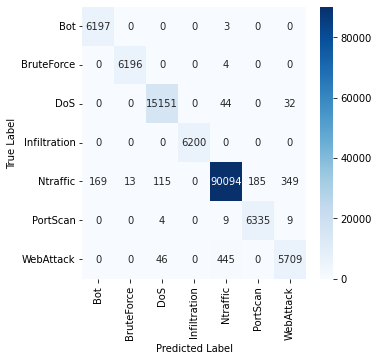

In [26]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined X_train, y_train, X_test, and y_test

# Fit the XGBoost classifier
xg = xgb.XGBClassifier(n_estimators=10)
xg.fit(X_train, y_train)

# Evaluate the model
xg_score = xg.score(X_test, y_test)
y_predict = xg.predict(X_test)
y_true = y_test
print('Accuracy of XGBoost: ' + str(xg_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))

# Print the classification report
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap
cm = confusion_matrix(y_true, y_predict)

# Rename the class labels in the confusion matrix
cm_renamed = cm.copy()
for i in range(len(target_names)):
    for j in range(len(target_names)):
        cm_renamed[i][j] = cm[target_names.index(target_names[i])][target_names.index(target_names[j])]

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_renamed, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [27]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 0.9952297373078239
Precision of RF: 0.99540342647739
Recall of RF: 0.9952297373078239
F1-score of RF: 0.9952689650034683
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.95      1.00      0.97      6200

    accuracy                           1.00    137309
   macro avg       0.99      1.00      0.99    137309
weighted avg       1.00      1.00      1.00    137309



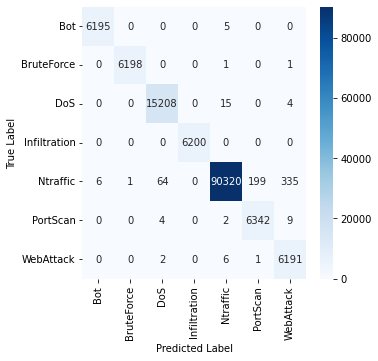

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined X_train, y_train, X_test, and y_test

# Fit the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate the model
rf_score = rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
y_true = y_test
print('Accuracy of RF: ' + str(rf_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [29]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

#### Apply DT

Accuracy of DT: 0.9949894034622639
Precision of DT: 0.9951739602998562
Recall of DT: 0.9949894034622639
F1-score of DT: 0.9950312792130998
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.94      1.00      0.97      6200

    accuracy                           0.99    137309
   macro avg       0.99      1.00      0.99    137309
weighted avg       1.00      0.99      1.00    137309



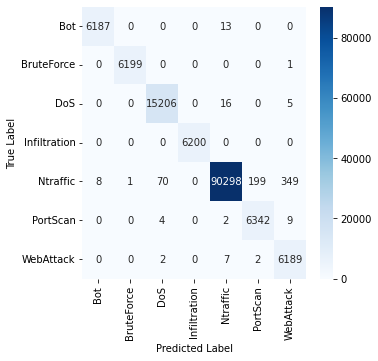

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined X_train, y_train, X_test, and y_test

# Fit the DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Evaluate the model
dt_score = dt.score(X_test, y_test)
y_predict = dt.predict(X_test)
y_true = y_test
print('Accuracy of DT: ' + str(dt_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [31]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

#### Apply ET

Accuracy of ET: 0.9952443029954336
Precision of ET: 0.9954171829751229
Recall of ET: 0.9952443029954336
F1-score of ET: 0.9952831427907423
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.95      1.00      0.97      6200

    accuracy                           1.00    137309
   macro avg       0.99      1.00      0.99    137309
weighted avg       1.00      1.00      1.00    137309



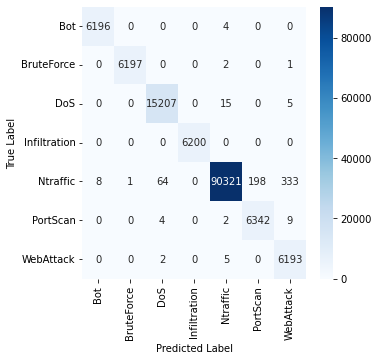

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined X_train, y_train, X_test, and y_test

# Fit the ExtraTreesClassifier
et = ExtraTreesClassifier(random_state=0)
et.fit(X_train, y_train)

# Evaluate the model
et_score = et.score(X_test, y_test)
y_predict = et.predict(X_test)
y_true = y_test
print('Accuracy of ET: ' + str(et_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


In [33]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [34]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,4,4,4,4
1,4,4,4,4
2,4,4,4,4
3,2,2,2,2
4,4,4,4,4


In [35]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [35]:
dt_train.shape

(452916, 1)

In [36]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9949894034622639
Precision of Stacking: 0.9951739602998562
Recall of Stacking: 0.9949894034622639
F1-score of Stacking: 0.9950312792130998
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.94      1.00      0.97      6200

    accuracy                           0.99    137309
   macro avg       0.99      1.00      0.99    137309
weighted avg       1.00      0.99      1.00    137309



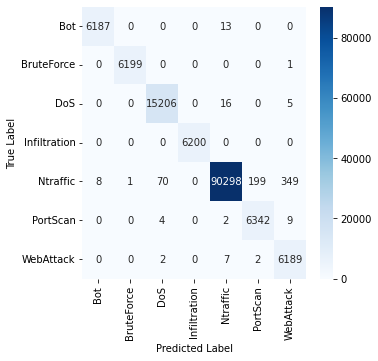

Execution Time: 96.46000742912292 seconds


In [37]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import time

# Record the starting time
start_time = time.time()


# Fit the XGBClassifier for stacking
stk = xgb.XGBClassifier().fit(x_train, y_train)

# Make predictions and evaluate the model
y_predict = stk.predict(x_test)
y_true = y_test
stk_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: ' + str(stk_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: ' + str(precision))
print('Recall of Stacking: ' + str(recall))
print('F1-score of Stacking: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()
# Calculate and print the execution time
end_time = time.time()
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

Accuracy of Stacking: 0.9949894034622639
Precision of Stacking: 0.9951739602998562
Recall of Stacking: 0.9949894034622639
F1-score of Stacking: 0.9950312792130998
              precision    recall  f1-score   support

         Bot       1.00      1.00      1.00      6200
  BruteForce       1.00      1.00      1.00      6200
         DoS       1.00      1.00      1.00     15227
Infiltration       1.00      1.00      1.00      6200
    Ntraffic       1.00      0.99      1.00     90925
    PortScan       0.97      1.00      0.98      6357
   WebAttack       0.94      1.00      0.97      6200

    accuracy                           0.99    137309
   macro avg       0.99      1.00      0.99    137309
weighted avg       1.00      0.99      1.00    137309



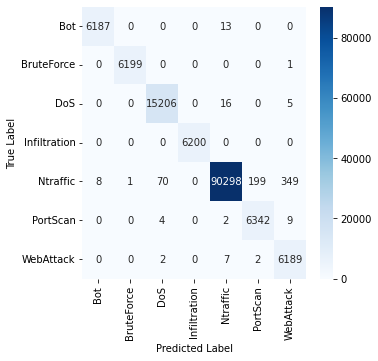

In [39]:

# Fit the XGBClassifier for stacking
stk = xgb.XGBClassifier().fit(x_train, y_train)

# Make predictions and evaluate the model
y_predict = stk.predict(x_test)
y_true = y_test
stk_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: ' + str(stk_score))

# Calculate precision, recall, and F1-score
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: ' + str(precision))
print('Recall of Stacking: ' + str(recall))
print('F1-score of Stacking: ' + str(fscore))

# Print the classification report with renamed class labels
target_names = ['Bot', 'BruteForce', 'DoS', 'Infiltration', 'Ntraffic', 'PortScan', 'WebAttack']
print(classification_report(y_true, y_predict, target_names=target_names))

# Create the confusion matrix and plot it as a heatmap with renamed class labels
cm = confusion_matrix(y_true, y_predict)

# Create a new figure and axes for the heatmap
f, ax = plt.subplots(figsize=(5, 5))

# Plot the heatmap with annotated values and the desired class labels
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# Set axis labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()


## PLOT IMPORTANCE FEATURES AFTER (IG & FCBE)

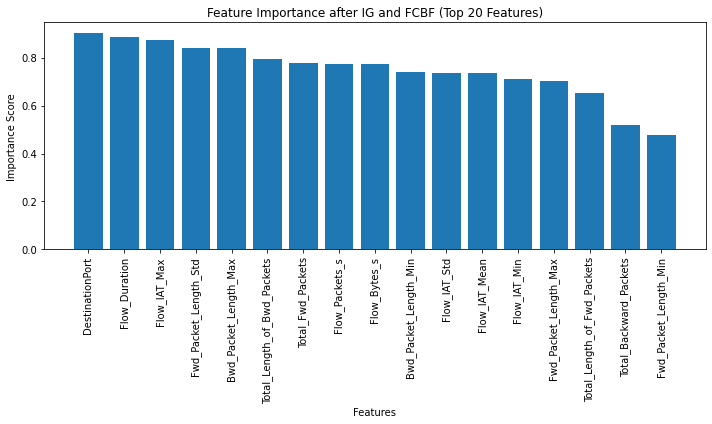

In [38]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from FCBF_module import FCBFK

# Calculate the feature importance scores using Information Gain (IG)
importances_ig = mutual_info_classif(X_train, y_train)

# Create a list of features
features = df.dtypes[df.dtypes != 'object'].index

# Calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances_ig), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

# Select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances_ig/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2 >= 0.9:
        break

# Apply Fast Correlation-Based Filter (FCBF)
#fcbf = FCBFK(k=20)
#X_fss = fcbf.fit_transform(X_train, y_train)

# Get the top 20 features
top_features = fs[:20]

# Get the importance scores of the top 20 features
top_importances = [importances_ig[features.get_loc(feature)] for feature in top_features]

# Plot the feature importance after IG and FCBF for the top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_importances)), top_importances)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance after IG and FCBF (Top 20 Features)')
plt.xticks(range(len(top_importances)), top_features, rotation='vertical')
plt.tight_layout()
plt.show()